# Bayesian MRF for segmentation 
## Natural image restortion

In [1]:
import numpy as np
import cv2

Convert XYZ image to L*u*v color space

In [2]:
no_regions = 2
beta=2.5
t = 0.05 #threshold
T0 = 4.00
c = 0.98

In [3]:
def RGB2Luv(in_data):
    height = in_data.shape[0]
    width = in_data.shape[1]
    xyz_data = np.zeros([height,width,3]).astype("float64")
    luv_data = np.zeros([height,width,3]).astype("float64")
    u0 = 4 * 242.36628 / (242.36628 + 15 * 254.999745 +  3 * 277.63227)
    v0 = 9 * 254.999754 / (242.36628 + 15 * 254.999745 +  3 * 277.63227)
    #Convert into CIE-XYZ color space
    for i in range(height):
        for j in range(width):
            #X component
            xyz_data[i][j][0] = (in_data[i][j][0] * 0.412453 +
                                 in_data[i][j][1] * 0.35758 +
                                 in_data[i][j][2] * 0.180423)
            # Y component
            xyz_data[i][j][1] = (in_data[i][j][0] * 0.212671 +
                                 in_data[i][j][1] * 0.715160 +
                                 in_data[i][j][2] * 0.072169)
            # Z component
            xyz_data[i][j][2] = (in_data[i][j][0] * 0.019334 +
                                 in_data[i][j][1] * 0.119193 +
                                 in_data[i][j][2] * 0.950227)
    #Convert into CIE-L*u*v color space
    for i in range(height):
        for j in range(width):
            if ((xyz_data[i][j][1]/254.999745) > 0.008856):
                luv_data[i][j][0] = 116*np.power(xyz_data[i][j][1]/264.999745, 1/3)-16
            else:
                luv_data[i][j][0] = 903.3*(xyz_data[i][j][1]/254.999745)
            #u component
            if ((xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])==0):
                luv_data[i][j][1] = 13 * luv_data[i][j][0] * (-u0)
            else:
                luv_data[i][j][1] = 13 * luv_data[i][j][0] * ((4 * xyz_data[i][j][0]/
                                                               (xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])) - u0)
    
            #v component
            if ((xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])==0):
                luv_data[i][j][2] = 13 * luv_data[i][j][0] * (-v0)
            else:
                luv_data[i][j][2] = 13 * luv_data[i][j][0] * ((9 * xyz_data[i][j][1] /
                                                               (xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])) - v0)
    
    return luv_data

Prior Guanssian distribution parameters

In [4]:
def CalculateMeanAndCovariance(frame):
    h=frame.shape[0]
    w=frame.shape[1]
    variance = np.zeros(3).astype("float64")
    mean = np.zeros(3).astype("float64")
    covariance = np.zeros(3).astype("float64")
    invcov = np.zeros(6).astype("float64")
    for k in range(3):
        frame_LUV = np.reshape(frame[:,:,k], -1)
        mean[k] = np.mean(frame_LUV)
        variance[k] = np.var(frame_LUV,ddof=1)
    #compute covariances
    frame_L = np.reshape(frame[:,:,0], -1)
    frame_u = np.reshape(frame[:,:,1], -1)
    frame_v = np.reshape(frame[:,:,2], -1)
    mean_L = mean[0]
    mean_u = mean[1]
    mean_v = mean[2]
    covariance[0] = np.sum((frame_L - mean_L)*(frame_u - mean_u))/(w*h)
    covariance[1] = np.sum((frame_L - mean_L)*(frame_v - mean_v))/(w*h)
    covariance[2] = np.sum((frame_u - mean_u)*(frame_v - mean_v))/(w*h)

    #compute elements of inverse covariance matrix
    invcov[0] = variance[2]*variance[1]-covariance[2]*covariance[2]
    invcov[1] = covariance[1]*covariance[2]-variance[2]*covariance[0]
    invcov[2] = covariance[0]*covariance[2]-variance[1]*covariance[1]
    invcov[3] = variance[2]*variance[0]-covariance[1]*covariance[1]
    invcov[4] = covariance[0]*covariance[1]-variance[0]*covariance[2]
    invcov[5] = variance[1]*variance[0]-covariance[0]*covariance[0]

    #compute denominator
    denom =  variance[0] * variance[1] * variance[2] - \
                          variance[2] * covariance[0] * covariance[0] - \
                          variance[1] * covariance[1] * covariance[1] - \
                          variance[0] * covariance[2] * covariance[2] + \
                          covariance[0] * covariance[1] * covariance[2] * 2
    return mean, variance, covariance, invcov, denom


In [5]:
def Singleton( i, j, label, image, mean, variance, covariance, invcov, denom):
    #determinate of covariance matrix
    in_image_data = image
    #print("Singleletion:", label)

    det = variance[0][label]*variance[1][label]*variance[2][label] + \
          2 * covariance[0][label]*covariance[1][label]*covariance[0][label] -\
          covariance[0][label]*covariance[0][label]*variance[2][label] - \
          covariance[1][label]*covariance[1][label]*variance[1][label] - \
          covariance[2][label]*covariance[2][label]*variance[0][label]

    gauss = ((in_image_data[i][j][0]-mean[0][label]) * invcov[0][label] + \
             (in_image_data[i][j][1]-mean[1][label]) * invcov[1][label] +\
             (in_image_data[i][j][2]-mean[2][label]) * invcov[2][label]) * (in_image_data[i][j][0]-mean[0][label]) + \
            ((in_image_data[i][j][0]-mean[0][label]) * invcov[1][label] + \
             (in_image_data[i][j][1]-mean[1][label]) * invcov[3][label] + \
             (in_image_data[i][j][2]-mean[2][label]) * invcov[4][label]) * (in_image_data[i][j][1]-mean[1][label]) +\
            ((in_image_data[i][j][0]-mean[0][label]) * invcov[2][label] + \
             (in_image_data[i][j][1]-mean[1][label]) * invcov[4][label] + \
             (in_image_data[i][j][2]-mean[2][label]) * invcov[5][label]) * (in_image_data[i][j][2]-mean[2][label])
    #print("in_image:",in_image_data[i][j], "-", mean[:,label])
    #print("gauss:",gauss)
    if(det==0):
        det = 1e-10
    elif(det < 0):
        det = -det
    if(denom[label]==0):
        denom[label]=1e-10
    return np.log(np.sqrt(2.0*np.pi*det)) + 0.5 * gauss / denom[label]

Analysis the data distrubution
The Singleletion vary with mean and variance

In [6]:
'''
singleenergy = []
for i in range(1000):
    mean = np.zeros([1,3])
    variance = np.zeros([1,3])
    covariance = np.zeros([1,3])
    invcov = np.zeros([1,6])
    denom = np.zeros([1])
    rgb_array = np.random.rand(3,3,3) * 255
    rgb_array = rgb_array.astype('uint8')
    img1 = img.astype('float32')
    img2 = cv2.cvtColor(img1, cv2.COLOR_RGB2XYZ)
    img3 = RGB2Luv(img2)
    height, width = img3.shape[0], img3.shape[1]
    mean[0], variance[0], covariance[0], invcov[0], denom[0] = CalculateMeanAndCovariance(rgb_array)
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    denom[denom==0]=1e-10
    singleenergy.append(Singleletion(0, 0, 0, img3, mean, variance, covariance, invcov, denom))

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.plot(singleenergy)
plt.xlabel('Data', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.grid(b=True, which='major', color='DarkTurquoise', alpha=0.4, linestyle=':', linewidth=2)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.2, linestyle='-', linewidth=2)
plt.show()
'''

"\nsingleenergy = []\nfor i in range(1000):\n    mean = np.zeros([1,3])\n    variance = np.zeros([1,3])\n    covariance = np.zeros([1,3])\n    invcov = np.zeros([1,6])\n    denom = np.zeros([1])\n    rgb_array = np.random.rand(3,3,3) * 255\n    rgb_array = rgb_array.astype('uint8')\n    img1 = img.astype('float32')\n    img2 = cv2.cvtColor(img1, cv2.COLOR_RGB2XYZ)\n    img3 = RGB2Luv(img2)\n    height, width = img3.shape[0], img3.shape[1]\n    mean[0], variance[0], covariance[0], invcov[0], denom[0] = CalculateMeanAndCovariance(rgb_array)\n    mean=(mean.T)\n    variance=(variance.T)\n    covariance=(covariance.T)\n    invcov=(invcov.T)\n    denom=(denom.T)\n    denom[denom==0]=1e-10\n    singleenergy.append(Singleletion(0, 0, 0, img3, mean, variance, covariance, invcov, denom))\n\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport scipy.stats as stats\nplt.plot(singleenergy)\nplt.xlabel('Data', fontsize=15)\nplt.ylabel('Value', fontsize=15)\nplt.grid(b=True, which='major', co

In [7]:
"""
Get the energy of the neighbors for each pixel and 
return the sum of their energies multiplied by beta 
in oder to calculate the doubletons 
(Doubleton: favours similar labels at neighbouring pixels – smoothness prior)
"""
def Doubleton(i, j, label, classes, beta, neighbors=4):
    energy = 0
    image_height, image_width = classes.shape[0], classes.shape[1]
    #print("Doubleton:", image_height, "x", image_width)
    #print("Doubleton: beta:", beta)
    #south
    if(i != image_height-1):
        if(label == classes[i+1][j]):
            energy -= 1
        else:
            energy += 1
    #east
    if(j != image_width-1):
        if(label == classes[i][j+1]):
            energy -= 1
        else:
            energy += 1
    #north
    if(i != 0):
        if(label == classes[i-1][j]):
            energy -= 1
        else:
            energy += 1
    #west
    if(i != image_height-1):
        if(label == classes[i][j-1]):
            energy -= 1
        else:
            energy += 1
    if(neighbors == 8):
            #southeast
            if(i != image_height-1) and (j != image_width-1):
                if(label == classes[i+1][j+1]):
                    energy -= 1
                else:
                    energy += 1
            #northeast
            if(i != 0) and (j != image_width-1):
                if(label == classes[i-1][j+1]):
                    energy -= 1
                else:
                    energy += 1
            #northwest
            if(i != 0) and (j != 0):
                if(label == classes[i-1][j-1]):
                    energy -= 1
                else:
                    energy += 1
            #southwest
            if(i != image_height-1) and (j != 0):
                if(label == classes[i][j-1]):
                    energy -= 1
                else:
                    energy += 1

    return energy*beta

In [8]:
def LocalEnergy(i, j, label, image, classes, mean, variance, covariance, invcov, denom, beta, neighbors):
    return Singleton(i,j,label,image,mean,variance,covariance,invcov,denom)+Doubleton(i,j,label,classes,beta,neighbors)

In [9]:
def CalculateEnergy(image, classes, mean, variance, covariance, invcov, denom, beta, neighbors):
    singletons = 0
    doubletons = 0
    image_height, image_width = image.shape[0], image.shape[1]
    for i in range(image_height):
        for j in range(image_width):
            k = classes[i,j]
            singletons += Singleton(i,j,k,image,mean, variance, covariance, invcov, denom)
            doubletons += Doubleton(i,j,k,classes,beta, neighbors) #each doubleton is counted twice
    #print("singletons:",singletons)
    #print("doubletons:",doubletons/2)
    return singletons+(doubletons/2)

In [10]:
# initialize using Maximum Likelihood
def SetInitClasses(image, mean, variance, covariance, invcov, denom):
    singletons = 0
    image_height, image_width = image.shape[0], image.shape[1]
    global no_regions
    classes = np.zeros([image_height, image_width]).astype("uint8")
    for i in range(image_height):
        for j in range(image_width):
            classes[i][j]=0
            e=Singleton(i,j,0,image, mean, variance, covariance, invcov, denom)
            for k in range(no_regions):
                e2 = Singleton(i,j,k,image, mean, variance, covariance, invcov, denom)
                if(e2 < e):
                    e = e2
                    classes[i,j] = k
    return classes

In [11]:
#gibbs sample
def gibbs(image, mean, variance, covariance, invcov, denom,beta, T0, c, t, neighbors=4):
    image_height, image_width = image.shape[0], image.shape[1]
    wholeEnergy = []
    wholeT = []
    Ek = np.zeros(no_regions) #local enegies
    classes = np.zeros([image_height, image_width]).astype('uint8')
    T = T0
    InitClasses = SetInitClasses(img3, mean, variance, covariance, invcov, denom)
    E_old = CalculateEnergy(image, InitClasses, mean, variance, covariance, invcov, denom,beta,neighbors)
    iterNo = 0
    while True:
        summa_deltaE = 0
        for i in range(image_height):
            for j in range(image_width):
                sumE = 0
                for s in range(no_regions):
                    Ek[s] = np.exp(-LocalEnergy(i,j,s,image,classes, mean, variance, covariance, invcov, denom,beta,neighbors)/T)
                    sumE +=Ek[s]
                #CDF
                z = 0
                r=np.random.uniform(size=1)
                for s in range(no_regions):
                    z +=Ek[s]/sumE
                    if(z>r):
                        classes[i][j]=s
                        break

        E = CalculateEnergy(image, classes, mean, variance, covariance, invcov, denom, beta,neighbors)
        summa_deltaE += np.abs(E_old-E)
        E_old = E
        T *= c
        iterNo += 1
        wholeT.append(T)
        wholeEnergy.append(E_old)
        #print("summa_deltaE:", summa_deltaE)
        print("T:", T)
        #print("Energy:", E)
        print('iterNo:', iterNo)

        if (summa_deltaE < t): # stop when energy change is small
            return classes, wholeEnergy, wholeT
            break

In [12]:
def outConvert(classes, image_height, image_width):
    classes = np.reshape(classes,(image_height,image_width))
    print(classes.shape)
    out_image = np.zeros([image_height,image_height,3]).astype("uint8")
    print(out_image.shape)
    for i in range(image_height):
        for j in range(image_width):
            if(classes[i][j]==0):
                out_image[i][j] = [219,182,125]#[125,182,219]
            elif(classes[i][j]==1):
                out_image[i][j] = [112,42,156]#[156, 42,112]
            elif(classes[i][j]==2):
                out_image[i][j] = [208,6,204]#[204,  6,208]
            elif(classes[i][j]==3):
                out_image[i][j] = [81,145,30]#[ 30,145, 81]
            else:
                out_image[i][j] = [ 0,0,255]
                
    return out_image

## Zebra

T: 3.92
iterNo: 1
T: 3.8415999999999997
iterNo: 2
T: 3.7647679999999997
iterNo: 3
T: 3.6894726399999995
iterNo: 4
T: 3.6156831871999993
iterNo: 5
T: 3.543369523455999
iterNo: 6
T: 3.4725021329868793
iterNo: 7
T: 3.4030520903271415
iterNo: 8
T: 3.3349910485205987
iterNo: 9
T: 3.2682912275501868
iterNo: 10
T: 3.202925402999183
iterNo: 11
T: 3.1388668949391993
iterNo: 12
T: 3.076089557040415
iterNo: 13
T: 3.014567765899607
iterNo: 14
T: 2.9542764105816146
iterNo: 15
T: 2.8951908823699823
iterNo: 16
T: 2.8372870647225827
iterNo: 17
T: 2.780541323428131
iterNo: 18
T: 2.7249304969595682
iterNo: 19
T: 2.670431887020377
iterNo: 20
T: 2.617023249279969
iterNo: 21
T: 2.56468278429437
iterNo: 22
T: 2.513389128608482
iterNo: 23
T: 2.4631213460363126
iterNo: 24
T: 2.413858919115586
iterNo: 25
T: 2.3655817407332744
iterNo: 26
T: 2.318270105918609
iterNo: 27
T: 2.271904703800237
iterNo: 28
T: 2.2264666097242323
iterNo: 29
T: 2.1819372775297476
iterNo: 30
T: 2.1382985319791525
iterNo: 31
T: 2.09553256

/users/micas/szhao/no_backup/software/anaconda3/envs/pyro/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


T: 0.09148210429942528
iterNo: 187
T: 0.08965246221343678
iterNo: 188
T: 0.08785941296916805
iterNo: 189
T: 0.08610222470978468
iterNo: 190
T: 0.08438018021558899
iterNo: 191
T: 0.08269257661127721
iterNo: 192
['Average time:20.304324239492416']


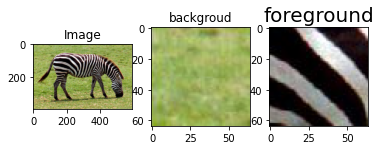

In [13]:
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ImageName = ["../input/zebra.jpg"]

OutImageList = []
WholeEnergyList = []
WholeTList = []
PSNRList = []
beta = 2.5
T0 = 4
c=0.98
threshold=0.05

#training pixels
points = np.array([[(0,0),(64,64)],[(200,100),(264,164)]])

fig = plt.figure()
for k in range(len(ImageName)):
    img=(mpimg.imread(ImageName[k]))
    ax = fig.add_subplot(1, 3, 1)
    imgplot = plt.imshow(img)
    ax.set_title('Image')
    
    ax = fig.add_subplot(1, 3, 2)
    refPoint = points[0]
    background_cropped = img[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
    imgplot = plt.imshow(background_cropped)
    ax.set_title('backgroud')
    
    ax = fig.add_subplot(1, 3, 3)
    refPoint = points[1]
    foreground_cropped = img[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
    imgplot = plt.imshow(foreground_cropped)
    ax.set_title('foreground', fontsize=20)
    
    #caculate mean, varience etc.
    mean = np.zeros([no_regions,3]).astype("float64")
    variance = np.zeros([no_regions, 3]).astype("float64")
    covariance = np.zeros([no_regions, 3]).astype("float64")
    invcov = np.zeros([no_regions, 6]).astype("float64")
    denom = np.zeros([no_regions]).astype("float64")
    OriImg = cv2.imread(ImageName[k])
    img = cv2.cvtColor(OriImg, cv2.COLOR_RGB2BGR)
    img1 = img.astype('float64')
    img3 = RGB2Luv(img1)
    i=0
    for refPoint in points:
        frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
        mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
        i+=1
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    
    #Gibbs sampler
    start_time = time.time()
    classes, wholeEnergy, wholeT=gibbs(img3, mean, variance, covariance, invcov, denom, beta, T0, c, threshold)
    timespent=(time.time()-start_time)/len(wholeEnergy)
    print(["Average time:"+str(timespent)])
    #OutImage=outConvert(classes)
    #psnr = cv2.PSNR(OriImg, OutImage.astype('uint8'))
    #print(["4 neighbors PSNR:"+str(psnr)])
    #PSNRList.append(psnr)
    #OutImageList.append(OutImage)
    #WholeEnergyList.append(wholeEnergy)
    #WholeTList.append(wholeT)
#plt.tight_layout()

In [14]:
#OutImage=outConvert(classes, OriImg.shape[0], OriImg.shape[1])
#psnr = cv2.PSNR(OriImg, OutImage.astype('uint8'))
print(classes.shape)
out_image = np.zeros([OriImg.shape[0],OriImg.shape[1],3]).astype("uint8")
print(out_image.shape)
for i in range(391):
    for j in range(586):
        if(classes[i][j]==0):
            out_image[i][j] = [0,0,0]#[125,182,219]
        elif(classes[i][j]==1):
            out_image[i][j] = [255,255,255]#[156, 42,112]
        else:
            out_image[i][j] = [ 0,0,255]

(391, 586)
(391, 586, 3)


Text(0.5, 1.0, 'After')

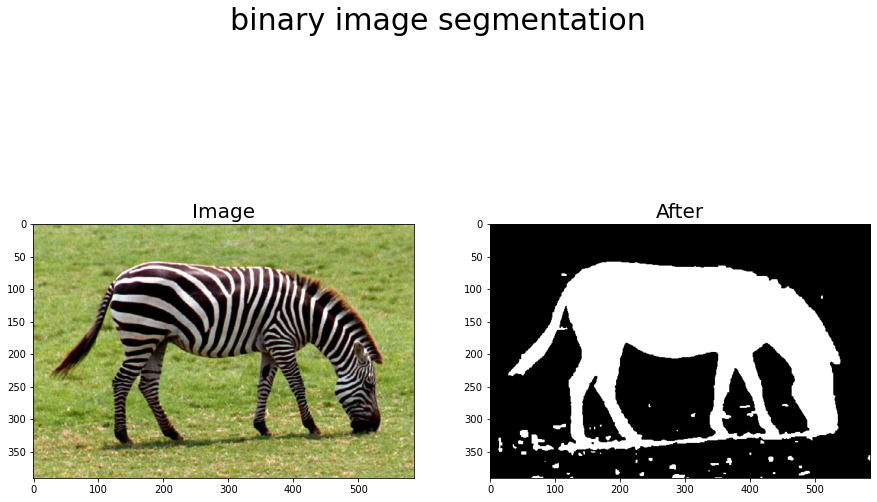

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(15,10))
fig.suptitle("binary image segmentation", fontsize=30)

ax = fig.add_subplot(1, 2, 1)
img=(mpimg.imread(ImageName[k]))
imgplot = plt.imshow(img)
ax.set_title('Image', fontsize=20)

ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(out_image)
ax.set_title('After', fontsize=20)

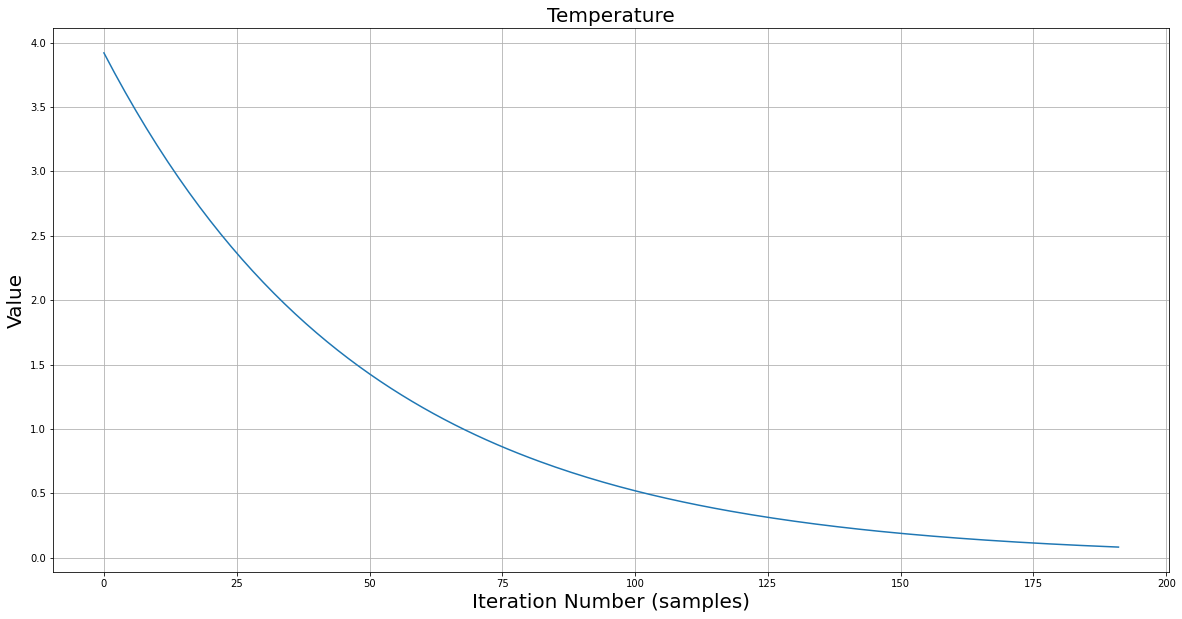

In [16]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Temperature', fontsize=20)
ax1.set_xlabel("Iteration Number (samples)", fontsize=20)
ax1.set_ylabel("Value",fontsize=20)

plt.plot(wholeT)
#ax1.legend(loc=4)
ax1.grid()
plt.show()

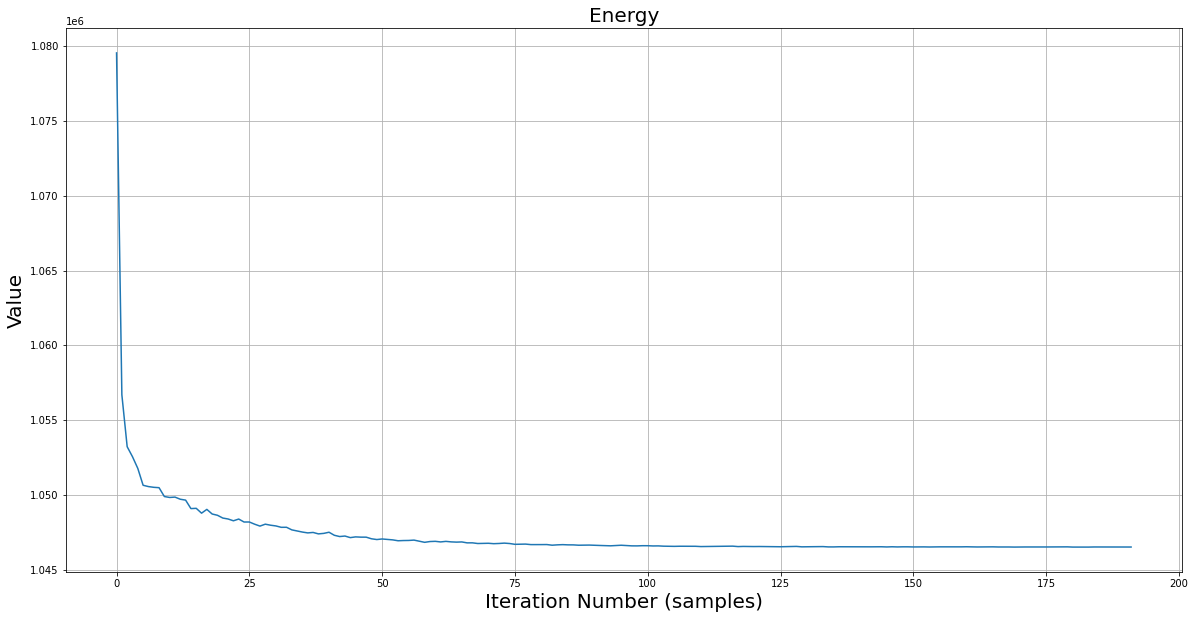

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Energy', fontsize=20)
ax1.set_xlabel("Iteration Number (samples)", fontsize=20)
ax1.set_ylabel("Value",fontsize=20)

plt.plot(wholeEnergy)
#ax1.legend(loc=4)
ax1.grid()
plt.show()